# Image segmentation

In [69]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import BatchNormalization
import cv2
from glob import glob
import datetime

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Initialization

In [105]:
image_dir = './data/raw/COVID-19_Radiography_Dataset/COVID/images/'
mask_dir = './data/raw/COVID-19_Radiography_Dataset/COVID/masks/'
model_dir = './checkpoints/'

In [103]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
BATCH_SIZE = 32  
EPOCHS = 10 
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 1e-4

# Preprocessing

In [6]:
image_files = sorted(glob(os.path.join(image_dir, '*.*')))
mask_files = sorted(glob(os.path.join(mask_dir, '*.*')))

In [7]:
len(image_files), len(mask_files)

(3616, 3616)

In [8]:
X = np.zeros((len(image_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
y = np.zeros((len(mask_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

In [10]:
X.shape, y.shape

((3616, 256, 256, 3), (3616, 256, 256, 1))

In [18]:
max(X[0].flatten())

np.float32(0.9411765)

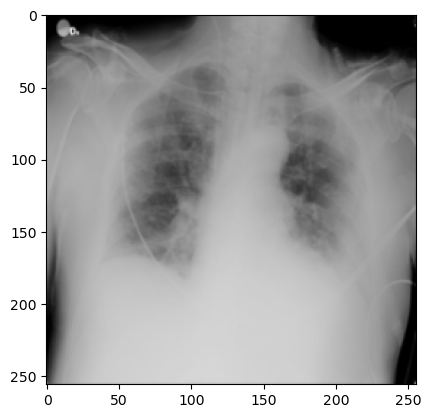

In [13]:
plt.imshow(X[0])

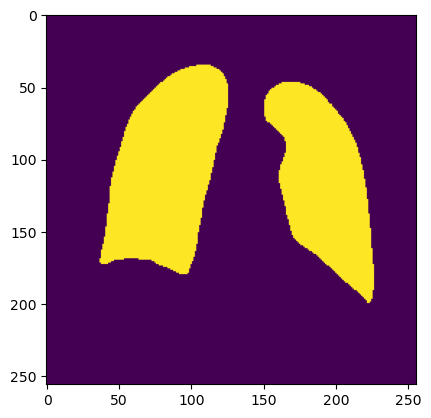

In [14]:
plt.imshow(y[0])

In [22]:
def load_data(image_path, mask_path):
    image_files = sorted(glob(os.path.join(image_path, '*.*')))
    mask_files = sorted(glob(os.path.join(mask_path, '*.*')))
    
    assert len(image_files) == len(mask_files), "Number of images and masks doesn't match!"
    print(f"Found {len(image_files)} images and masks")
    
    # Initialize arrays
    X = np.zeros((len(image_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
    y = np.zeros((len(mask_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    
    # Load images and masks
    for i, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
        if i % 1000 == 0:
            print(f"Processing image {i}/{len(image_files)}")
            
        # Load and resize image
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        X[i] = img / 255.0  
        
        # Load and resize mask
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        # Convert grayscale to binary (assuming mask is already binary)
        mask = (mask > 128).astype(np.float32)
        y[i] = np.expand_dims(mask, axis=-1)
    
    return X, y

In [23]:
X,y = load_data(image_dir, mask_dir)

Found 3616 images and masks
Processing image 0/3616
Processing image 1000/3616
Processing image 2000/3616
Processing image 3000/3616


In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VALIDATION_SPLIT, random_state=42)

# Create dataset

In [25]:
def create_dataset(X, y, batch_size, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    
    if is_training:
        # Shuffle the dataset for training
        dataset = dataset.shuffle(buffer_size=len(X))
        
        # Data augmentation using tf.data - more efficient on GPU
        def augment(image, mask):
            # Random flip left-right
            if tf.random.uniform(()) > 0.5:
                image = tf.image.flip_left_right(image)
                mask = tf.image.flip_left_right(mask)
            
            # Random flip up-down
            if tf.random.uniform(()) > 0.5:
                image = tf.image.flip_up_down(image)
                mask = tf.image.flip_up_down(mask)
            
            # Random brightness adjustment
            image = tf.image.random_brightness(image, 0.1)
            
            # Ensure image values stay in [0,1]
            image = tf.clip_by_value(image, 0, 1)
            
            return image, mask
        
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Batch and prefetch for performance
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

## Exploring the dataset object in tensorflow

In [26]:
train_ds = create_dataset(X_train, y_train, BATCH_SIZE, is_training=True)
val_ds = create_dataset(X_val, y_val, BATCH_SIZE, is_training=False)

In [30]:
train_ds.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))

In [39]:
train_ds.element_spec[0].shape

TensorShape([None, 256, 256, 3])

In [34]:
iterator = iter(train_ds)
image, mask = next(iterator)
image.shape

TensorShape([32, 256, 256, 3])

In [37]:
type(image[0])

tensorflow.python.framework.ops.EagerTensor

In [38]:
image[0].shape

TensorShape([256, 256, 3])

In [49]:
example_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [50]:
example_ds.element_spec

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None))

In [51]:
example_ds.element_spec[0]

TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None)

In [53]:
X_train.shape

(2892, 256, 256, 3)

In [59]:
batched_example = example_ds.batch(32, drop_remainder=True)
batched_example.element_spec

(TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32, 256, 256, 1), dtype=tf.float32, name=None))

In [61]:
# Without drop_remainder=True the shape of the output dataset will have an unknown leading dimension due to the possibility of a smaller final batch.
# None in the first dimension indicate that the batch size is not fixed.
batched_example = example_ds.batch(32)
batched_example.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))

# Model

In [70]:
# Define advanced U-Net model with batch normalization for better training
def build_unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    """Build U-Net model architecture with batch normalization"""

    
    inputs = Input(input_size)
    
    # Encoder (Contracting Path)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bridge
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    
    # Decoder (Expansive Path)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)
    
    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [71]:
unet = build_unet_model((256, 256, 3))

In [73]:
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[

 Total params: 1,946,993 (7.43 MB)

 Trainable params: 1,944,049 (7.42 MB)

 Non-trainable params: 2,944 (11.50 KB)

## Evaluation metric

$ Dice = (2 × |A ∩ B|) / (|A| + |B|) $

where $ A $ and $ B $ represents **Ground truth mask** and **Predicted mask**

In [74]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

### Application of Dice Coefficient 

In [87]:
y_true = np.random.randint(0, 2, (1, 5, 5, 1)).astype(np.float32)  # Binary ground truth
y_pred = np.random.uniform(0, 1, (1, 5, 5, 1)).astype(np.float32)  # Probabilities from model

In [91]:
dice = dice_coefficient(y_true, y_pred)
print(f"Dice coefficient: {dice:.4f}")

Dice coefficient: 0.4446


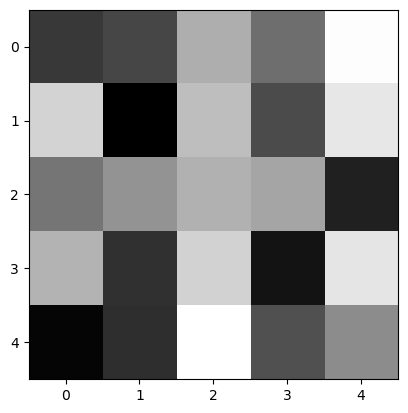

In [89]:
plt.imshow(y_pred[0, :, :, 0], cmap='gray')

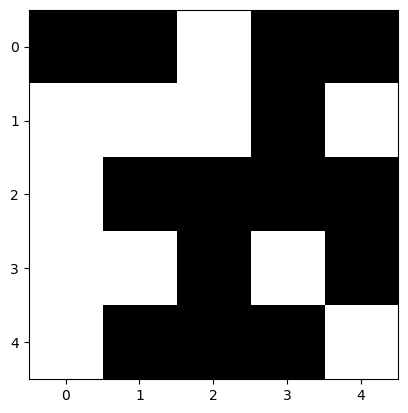

In [90]:
plt.imshow(y_true[0, :, :, 0], cmap='gray')

In [92]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [94]:
def bce_dice_loss(y_true, y_pred):
    # Ensure both inputs are the same type
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

## IoU Metric (Intersection over Union)
**IoU** measures how much the predicted segmentation overlaps with the ground truth segmentation. It's also called the **Jaccard Index**.

$ IoU = Area of Overlap / Area of Union  $

$ IoU
      = (A ∩ B) / (A ∪ B) $

In [133]:
def calculate_metrics(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    # Intersection over Union (IoU)
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    iou = intersection / (union + 1e-10)
    
    # Dice coefficient
    dice = (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1e-10)
    
    # Pixel accuracy
    accuracy = np.mean(y_true_f == y_pred_f)
    
    # Precision and recall
    true_positives = np.sum(y_true_f * y_pred_f)
    all_positives = np.sum(y_pred_f)
    all_trues = np.sum(y_true_f)
    
    precision = true_positives / (all_positives + 1e-10)
    recall = true_positives / (all_trues + 1e-10)
    
    # F1 score
    f1 = 2 * precision * recall / (precision + recall + 1e-10)
    
    return {
        'iou': iou,
        'dice': dice,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Build Model and train

In [96]:
log_dir = './train_logs'

In [97]:
model = build_unet_model((256, 256, 3))
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=bce_dice_loss,
    metrics=['accuracy', dice_coefficient, tf.keras.metrics.MeanIoU(num_classes=2)]
)

In [98]:
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint = ModelCheckpoint(
    'unet_model_best.keras',
    monitor='val_dice_coefficient',
    verbose=1,
    save_best_only=True,
    mode='max'
)
early_stopping = EarlyStopping(
    patience=15,
    verbose=1,
    monitor='val_dice_coefficient',
    mode='max',
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_dice_coefficient',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    mode='max',
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr, tensorboard_callback]

In [104]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/10


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6784 - dice_coefficient: 0.4681 - loss: 1.1227 - mean_io_u_1: 0.3779
Epoch 1: val_dice_coefficient improved from None to 0.43590, saving model to unet_model_best.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.7652 - dice_coefficient: 0.5358 - loss: 0.9559 - mean_io_u_1: 0.3778 - val_accuracy: 0.8326 - val_dice_coefficient: 0.4359 - val_loss: 1.0582 - val_mean_io_u_1: 0.3768 - learning_rate: 1.0000e-04
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9244 - dice_coefficient: 0.6819 - loss: 0.6098 - mean_io_u_1: 0.3771
Epoch 2: val_dice_coefficient improved from 0.43590 to 0.57940, saving model to unet_model_best.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 0.9320 - dice_coefficient: 0.6988 - loss: 0.5739 - mean_io_u_1: 0.3778 - val_accuracy: 0.8591 - val_dice_coefficient: 0.5794 - val_loss: 0.8117 - val_mean_io_u_1: 0.3768 - learning_rate: 1.0000e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/st

In [108]:
model_dir = model_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.h5'
model.save(model_dir)

# Evaluation

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Dice Coefficient')]

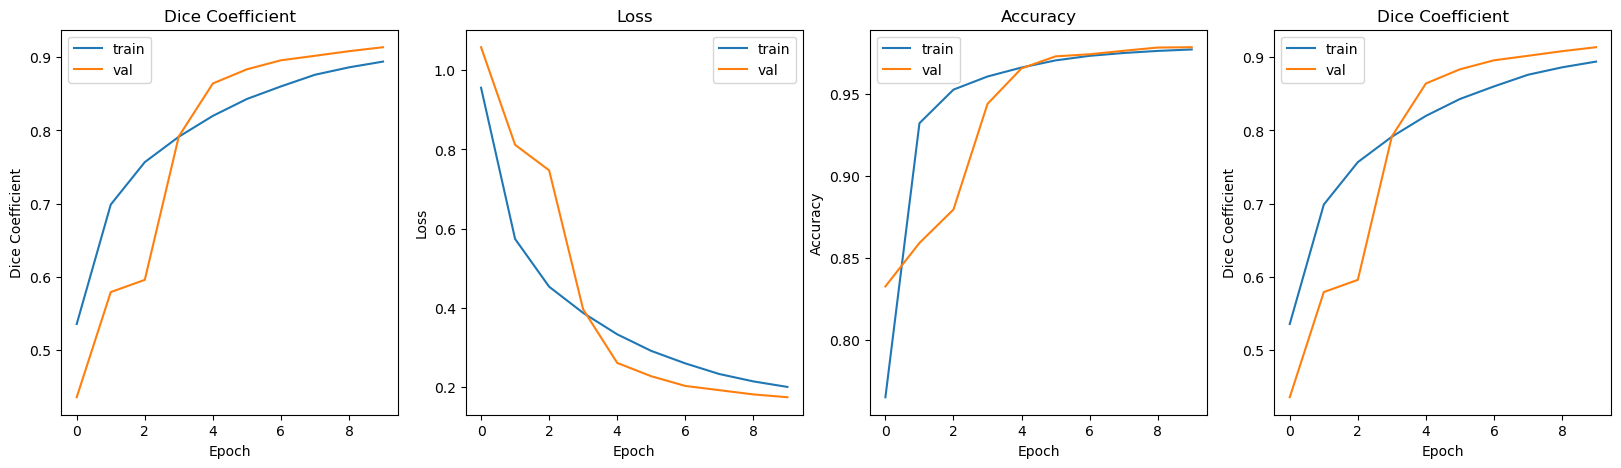

In [129]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
ax1.plot(history.history['dice_coefficient'])
ax1.plot(history.history['val_dice_coefficient'])
ax1.set_title('Dice Coefficient')
ax1.legend(['train', 'val'])
ax1.set(xlabel='Epoch', ylabel='Dice Coefficient')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Loss')
ax2.legend(['train', 'val'])
ax2.set(xlabel='Epoch', ylabel='Loss')

ax3.plot(history.history['accuracy'])
ax3.plot(history.history['val_accuracy'])
ax3.set_title('Accuracy')
ax3.legend(['train', 'val'])
ax3.set(xlabel='Epoch', ylabel='Accuracy')

ax4.plot(history.history['dice_coefficient'])
ax4.plot(history.history['val_dice_coefficient'])
ax4.set_title('Dice Coefficient')
ax4.legend(['train', 'val'])
ax4.set(xlabel='Epoch', ylabel='Dice Coefficient')

# Prediction

In [130]:
print("Making predictions...")
# Convert validation data to batches for prediction
val_pred_batches = []
for batch in val_ds:
    X_batch, _ = batch
    pred_batch = model.predict(X_batch)
    val_pred_batches.append(pred_batch)

# Combine predictions 
preds_val = np.vstack(val_pred_batches)
preds_val = preds_val[:len(X_val)]  # Trim excess predictions from last batch
preds_val_binary = (preds_val > 0.5).astype(np.float32)

Making predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


2025-10-02 14:23:37.728957: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
def display_predictions(X, y_true, y_pred, num_samples=3):
    plt.figure(figsize=(15, 5*num_samples))
    for i in range(num_samples):
        plt.subplot(num_samples, 4, i*4+1)
        plt.imshow(X[i])
        plt.title(f'Image {i+1}')
        plt.axis('off')
        
        # Display true mask
        plt.subplot(num_samples, 4, i*4+2)
        plt.imshow(y_true[i].squeeze(), cmap='gray')
        plt.title(f'True Mask {i+1}')
        plt.axis('off')
        
        # Display predicted mask
        plt.subplot(num_samples, 4, i*4+3)
        plt.imshow(y_pred[i].squeeze(), cmap='gray')
        plt.title(f'Pred Mask {i+1}')
        plt.axis('off')
        
        # Display image with predicted mask overlay
        plt.subplot(num_samples, 4, i*4+4)
        plt.imshow(X[i])
        plt.imshow(y_pred[i].squeeze(), alpha=0.5, cmap='Reds')
        plt.title(f'Overlay {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Displaying validation results:


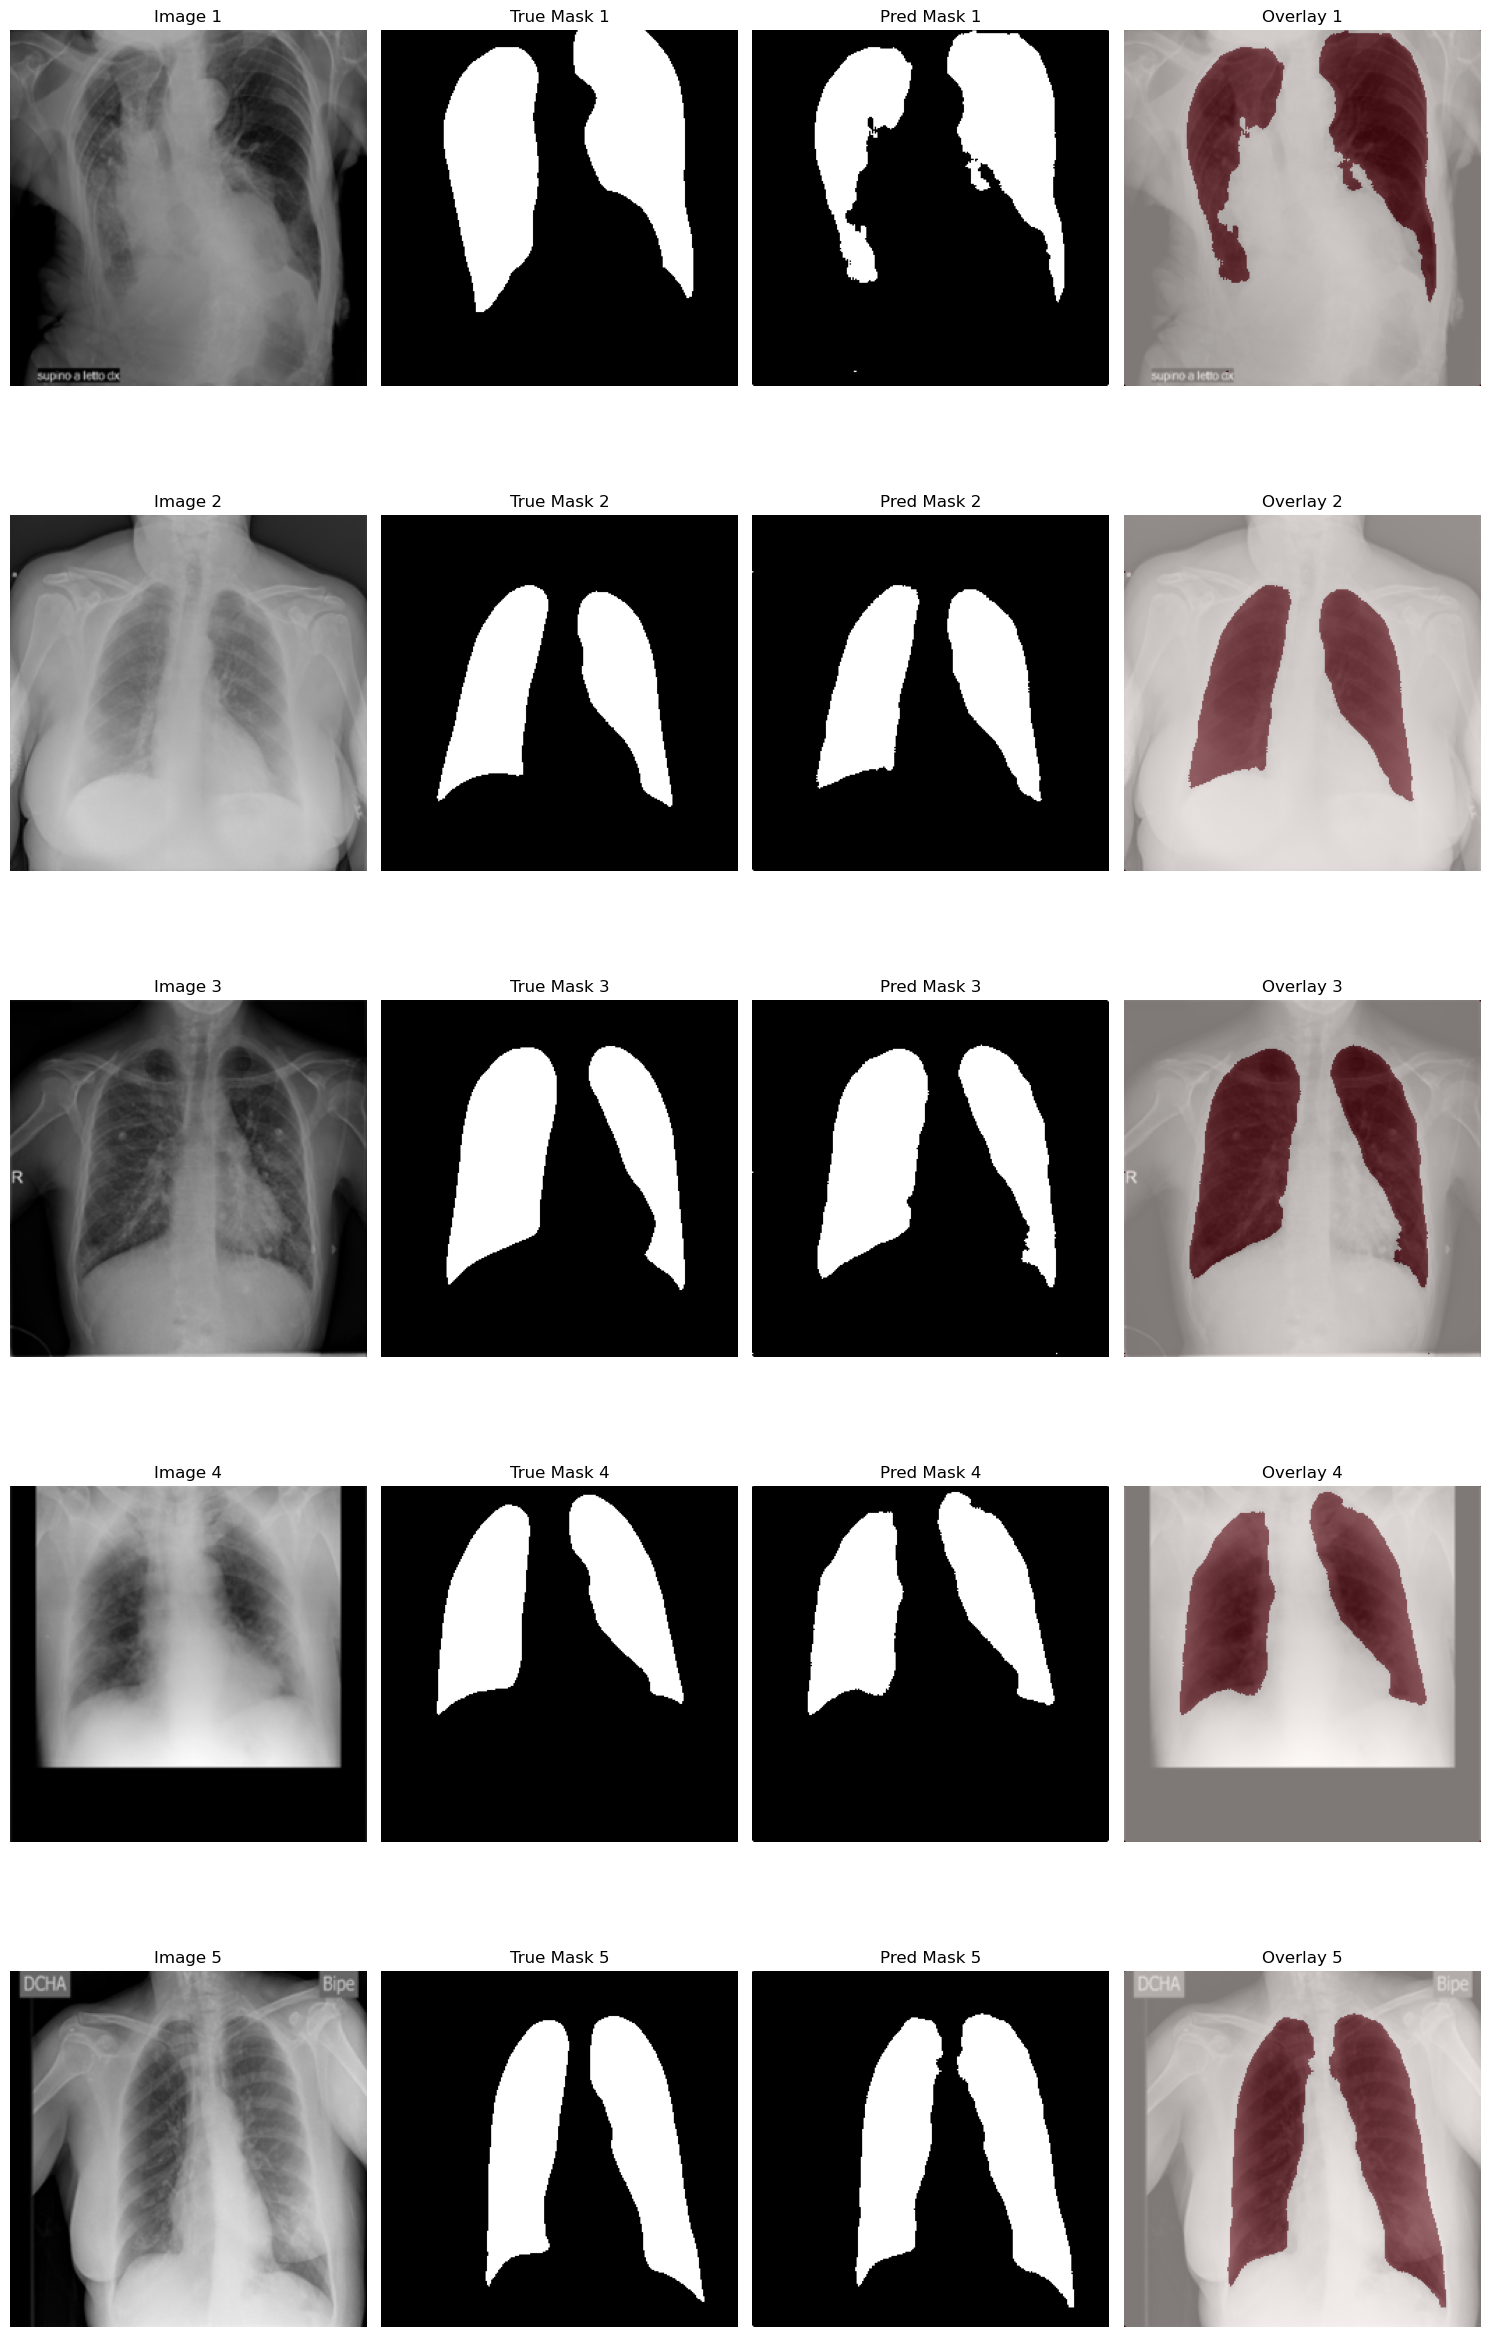

In [132]:
print("Displaying validation results:")
display_predictions(X_val, y_val, preds_val_binary, num_samples=5)

In [134]:
metrics_list = [calculate_metrics(y_val[i], preds_val_binary[i]) for i in range(len(y_val))]
mean_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0].keys()}

print("\nValidation Metrics:")
for metric, value in mean_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")


Validation Metrics:
Iou: 0.9142
Dice: 0.9532
Accuracy: 0.9782
Precision: 0.9535
Recall: 0.9571
F1: 0.9532
